In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import os
import sys
import multiprocessing as mp
import datetime as dt
#import oci
#import ads

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC

In [5]:
plt.rcParams["figure.figsize"] = (24, 16)

In [33]:
import umap
import umap.plot

In [ ]:
import hdbscan

In [2]:
penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv")
penguins = penguins.dropna()
penguins.head()

,species_short,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [3]:
penguins.shape

(334, 7)

In [4]:
penguins.species_short.value_counts()

Adelie       146
Gentoo       120
Chinstrap     68
Name: species_short, dtype: int64

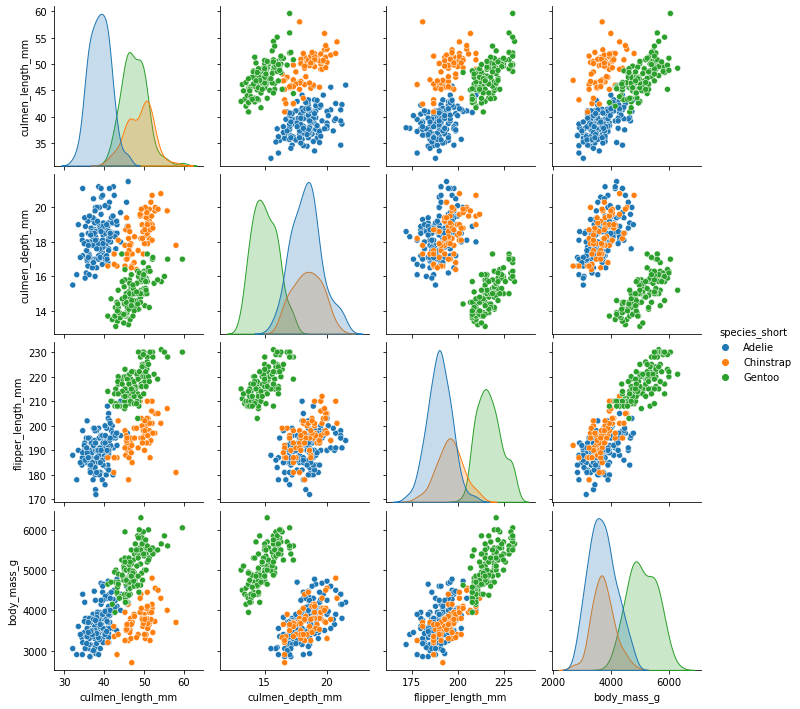

In [7]:
sns.pairplot(penguins, hue='species_short')

### Example-1 :  penguin

In [9]:
reducer = umap.UMAP()

In [10]:
# convert data to z-score 
penguin_data = penguins[
    [
        "culmen_length_mm",
        "culmen_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

In [12]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(334, 2)

In [25]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

Text(0.5, 1.0, 'UMAP projection of the Penguin dataset')

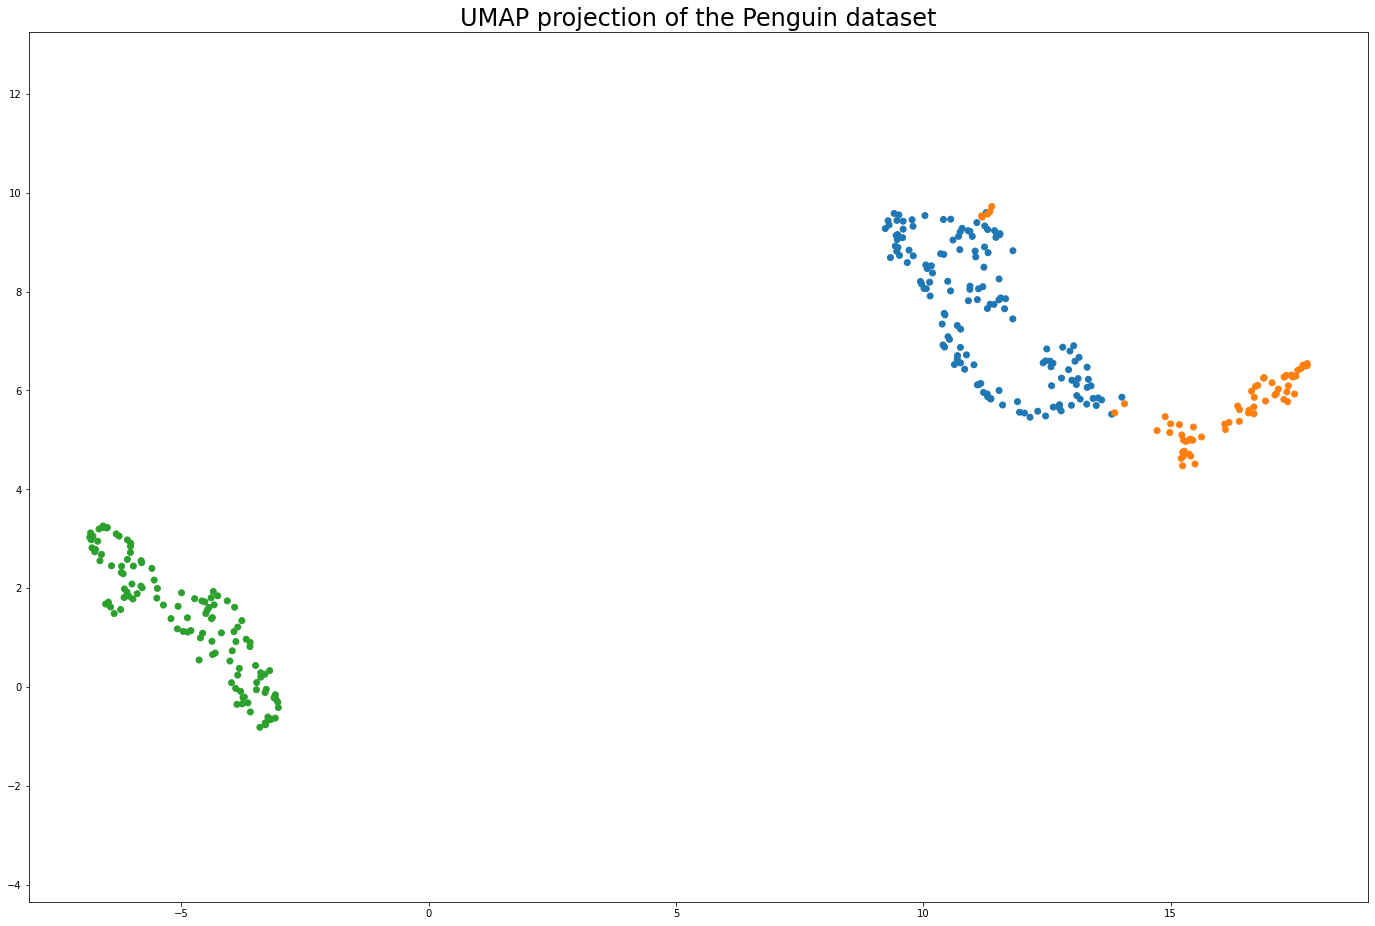

In [15]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

### Example-2 :  digits

In [16]:
digits = load_digits()

In [21]:
reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)
'''
UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
'''

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [32]:
embedding = reducer.transform(digits.data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute in reducer
assert(np.all(embedding == reducer.embedding_)) 
embedding.shape

(1797, 2)

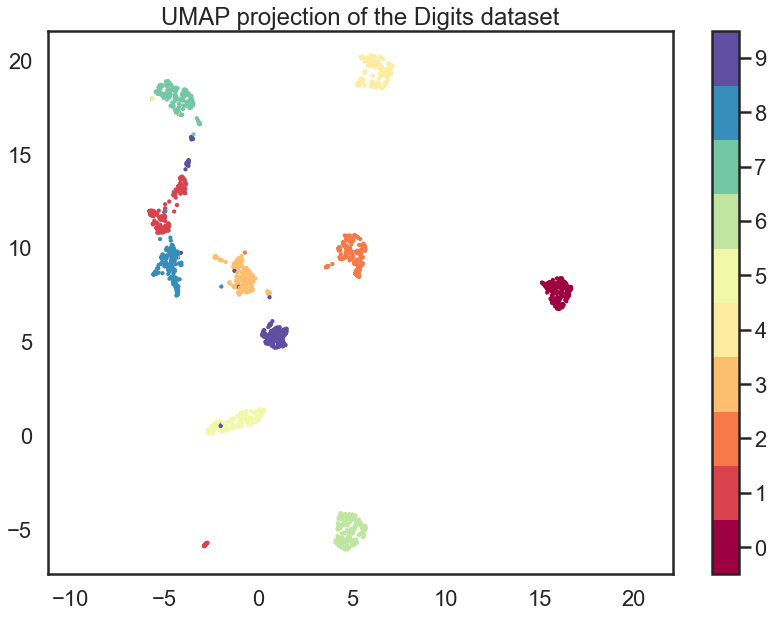

In [33]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

### Example 3 : Train & Test models 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target,
                                                    stratify=digits.target,
                                                    random_state=42)

In [36]:
svc = SVC().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)

In [37]:
svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.9911111111111112, 0.9844444444444445)

### try using UMAP first

In [38]:
trans = umap.UMAP(n_neighbors=5, n_components=2, random_state=42).fit(X_train)

In [42]:
svc = SVC().fit(trans.embedding_, y_train)
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

In [43]:
test_embedding = trans.transform(X_test)

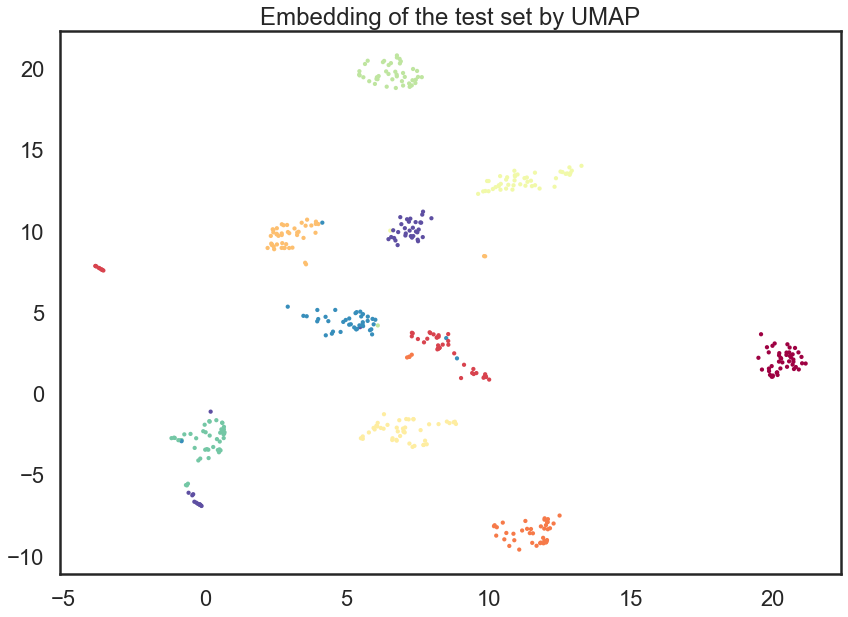

In [44]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24);

In [45]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.9688888888888889, 0.9822222222222222)

### Example 4 : Clustering 

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [10]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

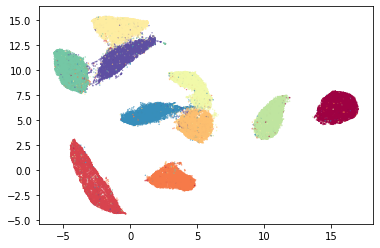

In [16]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

In [23]:
mnist.data.shape

(70000, 784)

In [25]:
# use standard PCA for dimantion reduction for HDBSCAN clustering
lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=200).fit_predict(lowd_mnist)

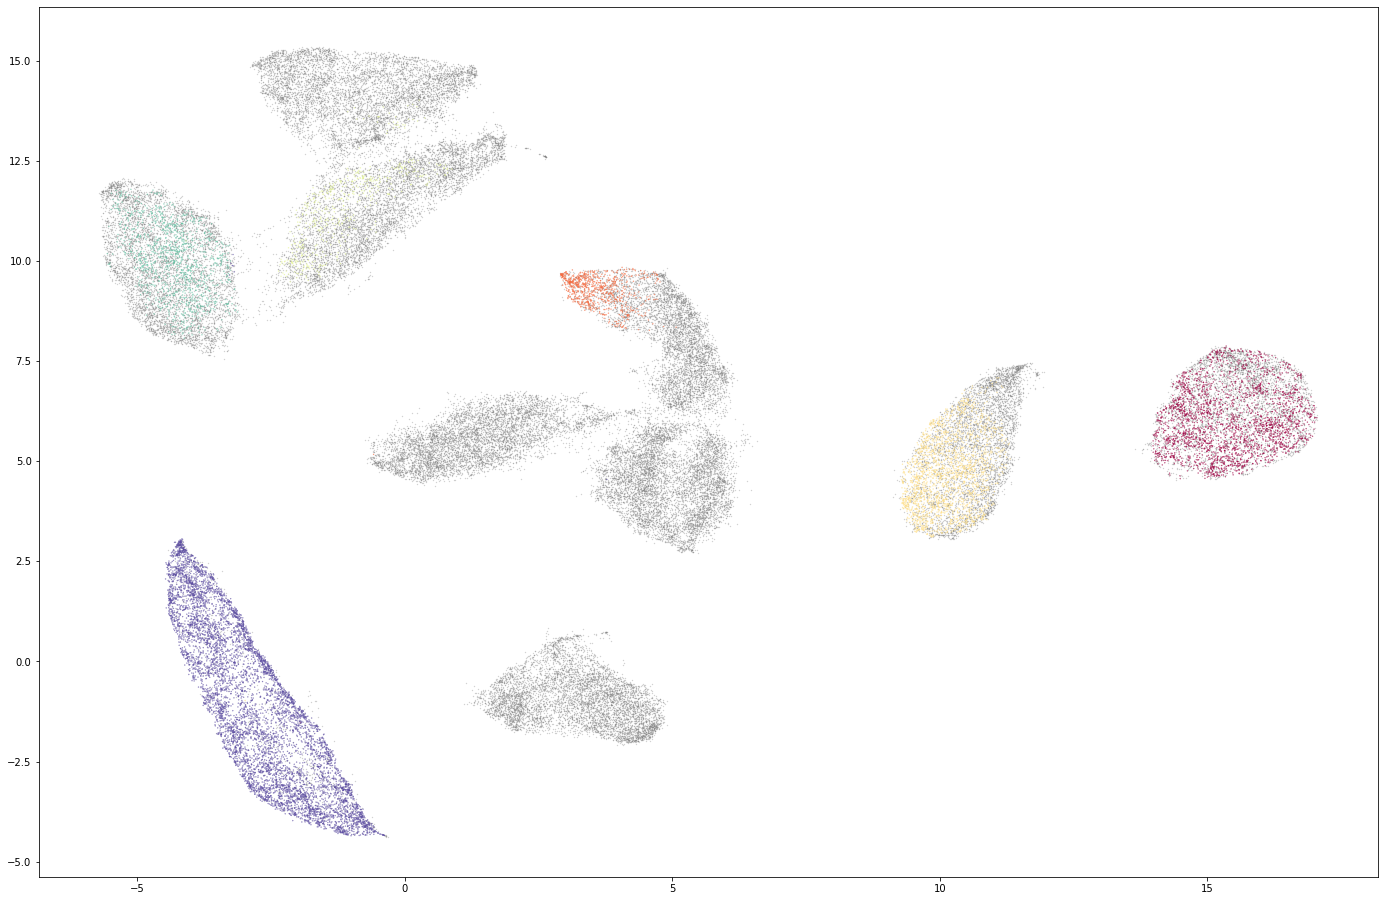

In [26]:
clustered = (hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [27]:
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(mnist.target[clustered], hdbscan_labels[clustered])
)

(0.9977354595501586, 0.9923721203977401)

In [28]:
np.sum(clustered) / mnist.data.shape[0]

0.20745714285714287

##### Use UMAP dimention redaction for HDBSCAN clustering

In [51]:
clusterable_embedding = umap.UMAP(
    n_neighbors=35,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(mnist.data)

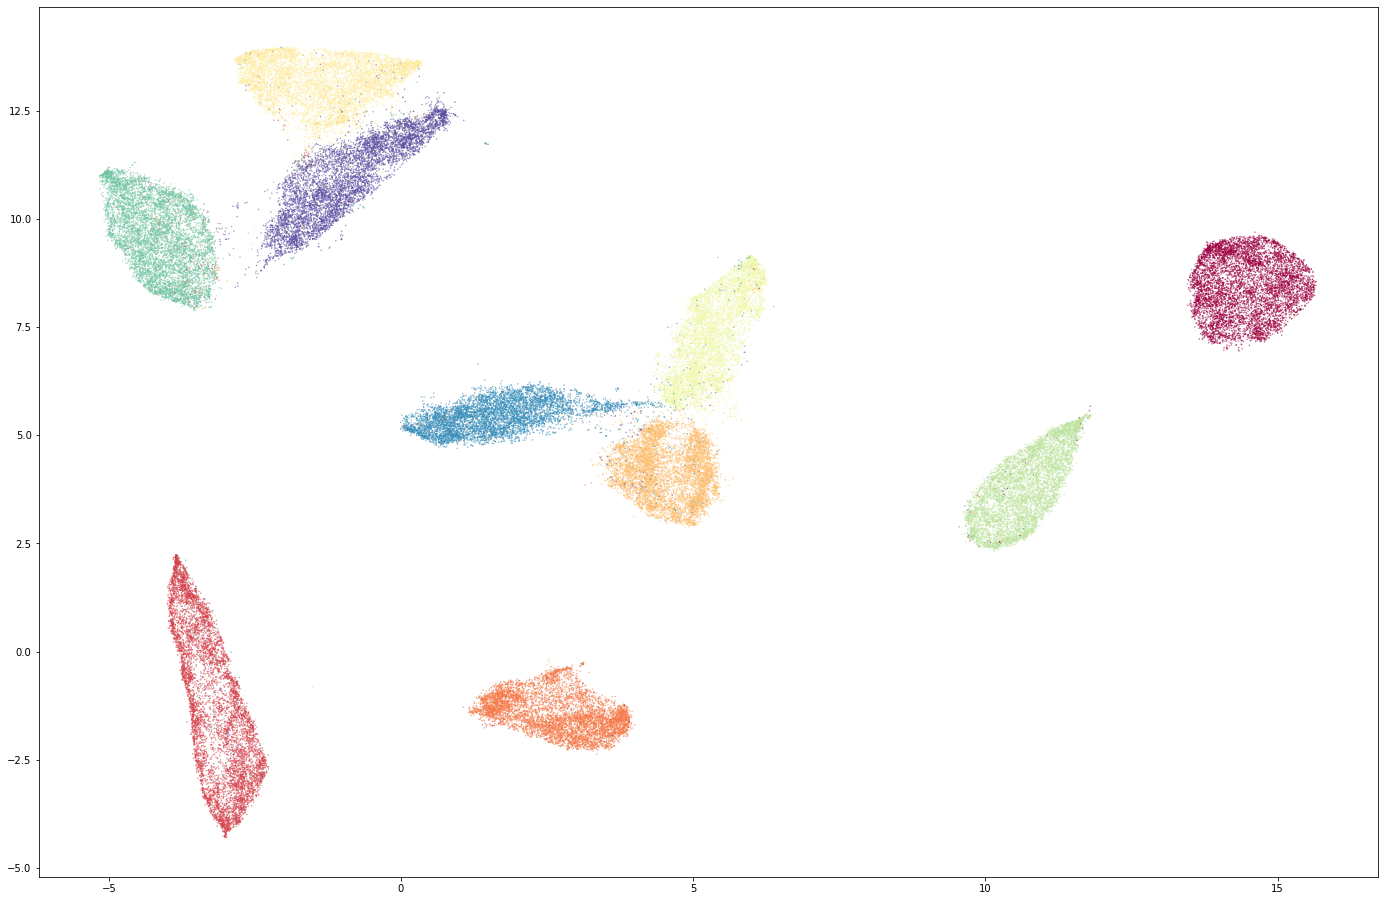

In [52]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=mnist.target, s=0.1, cmap='Spectral');

In [53]:
labels = hdbscan.HDBSCAN(
    min_samples=8,
    min_cluster_size=400,
).fit_predict(clusterable_embedding)

In [80]:
labels

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

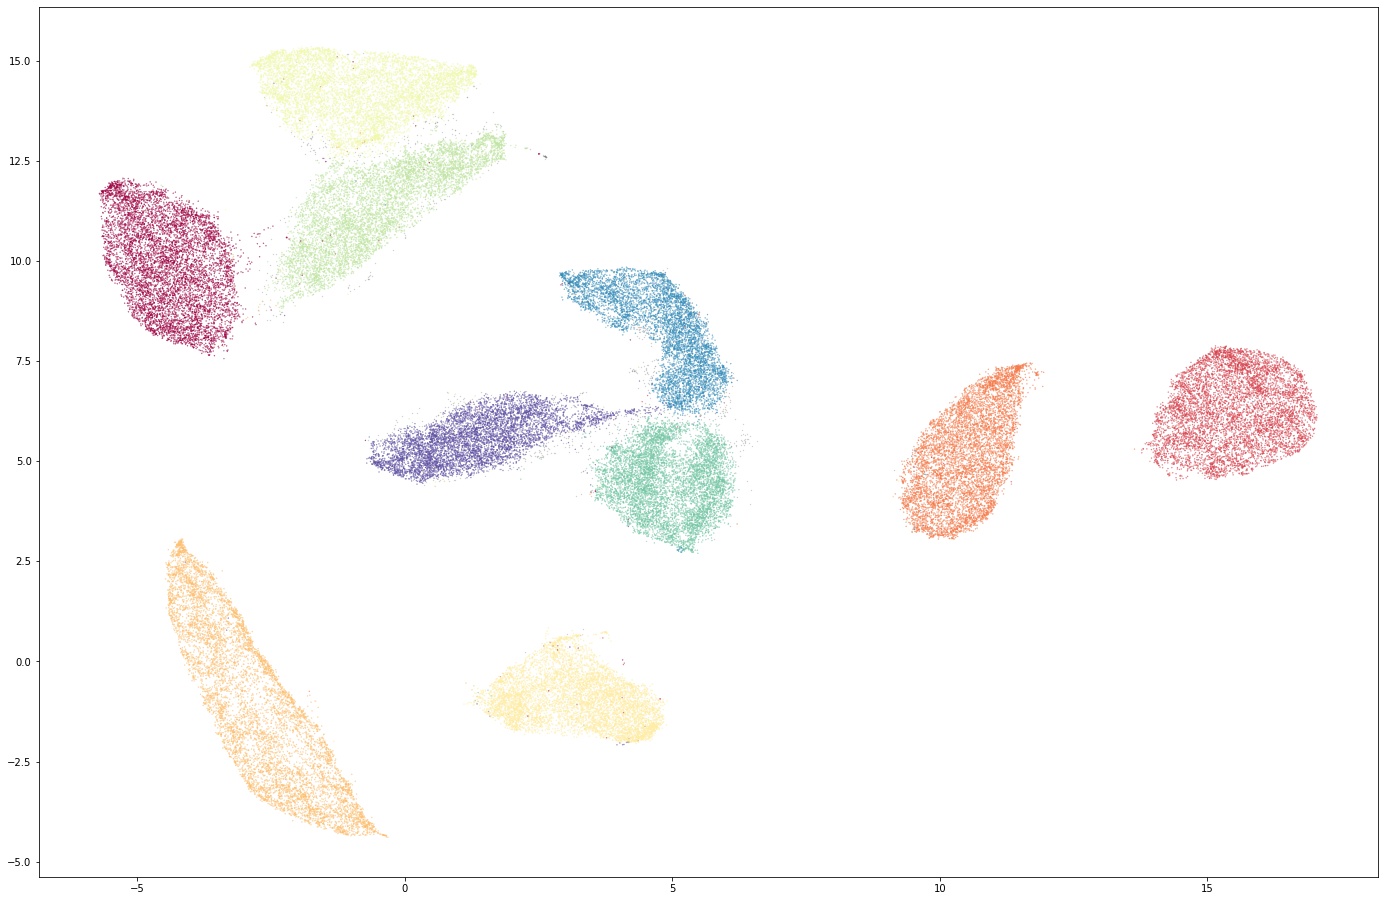

In [54]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [55]:
clustered = (labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], labels[clustered]),
    adjusted_mutual_info_score(mnist.target[clustered], labels[clustered])
)

(0.9333286031538168, 0.9203645565323125)

In [56]:
np.sum(clustered) / mnist.data.shape[0]

0.9867714285714285

### Example 5 : Outliers detection

In [58]:
data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [59]:
data.shape

(70000, 784)

In [71]:
mapper = umap.UMAP(set_op_mix_ratio=0.25).fit(data) #

<AxesSubplot:>

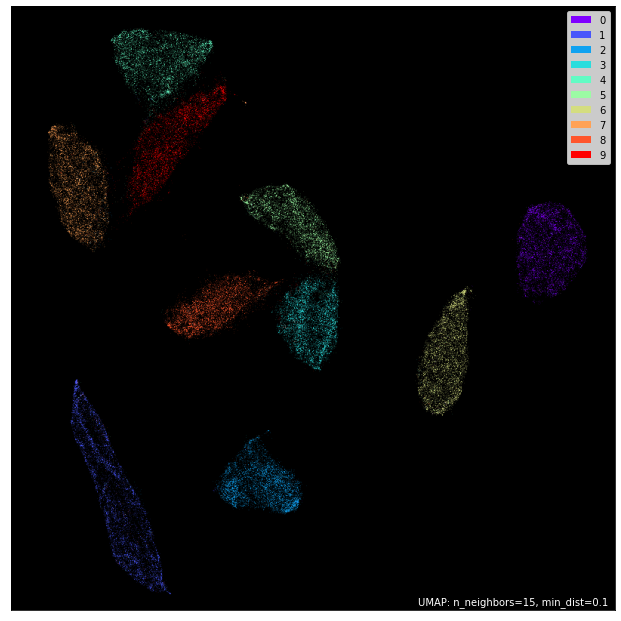

In [79]:
umap.plot.points(mapper, labels=labels, theme='fire')

In [73]:
# contamination = 100 / 70000
outlier_scores = LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

In [105]:
outlying_digits = data[outlier_scores == -1]

### Example 6 : Random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
digits = load_digits()

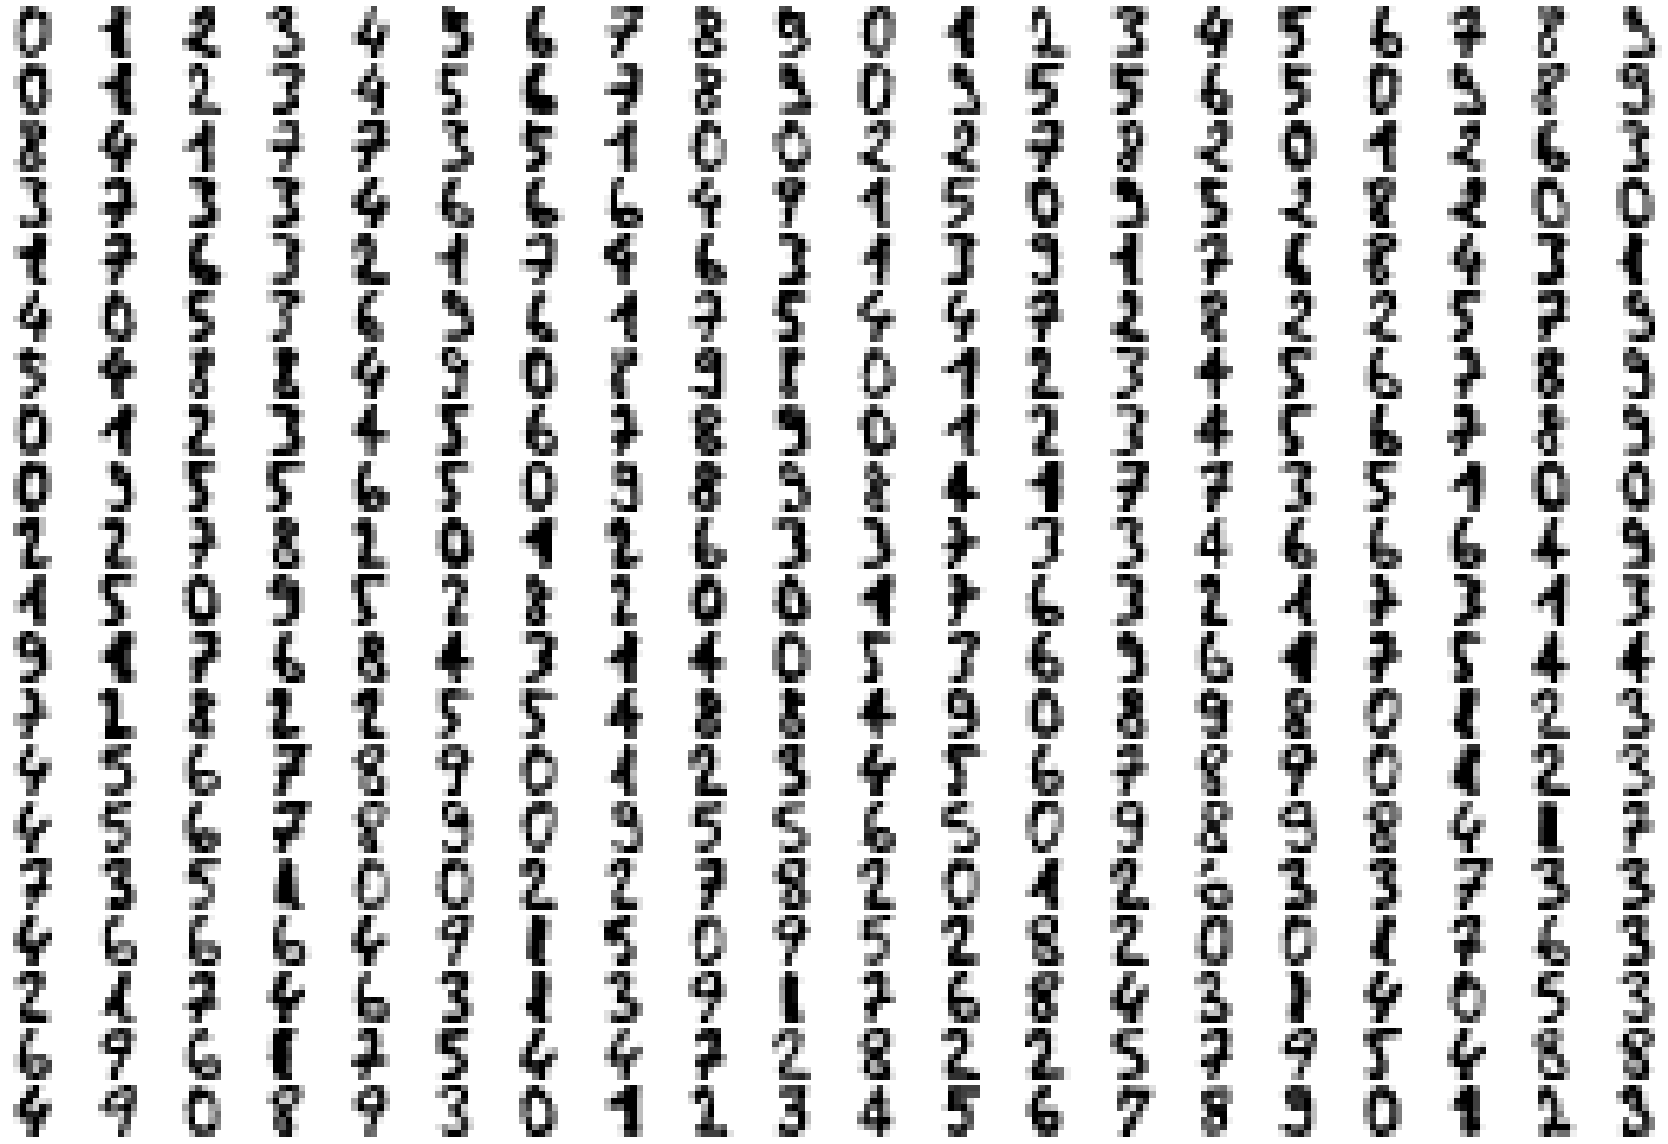

In [31]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [11]:
# data is image 28x28 pixals vector of a digit 0..9
# labels is the label of the bnumber 0..9
data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [29]:
data.shape

(70000, 784)

In [22]:
labels

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

#### Reduce from 728 to 2D space using UMAP

In [12]:
umapper = umap.UMAP(
    n_neighbors=35,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit(data)

In [13]:
embedding = umapper.transform(data)

<AxesSubplot:>

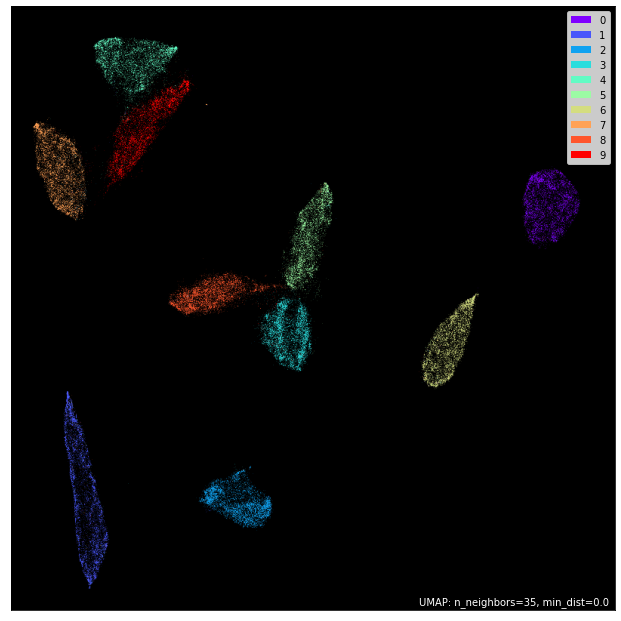

In [15]:
umap.plot.points(umapper, labels=labels, theme='fire')

<AxesSubplot:>

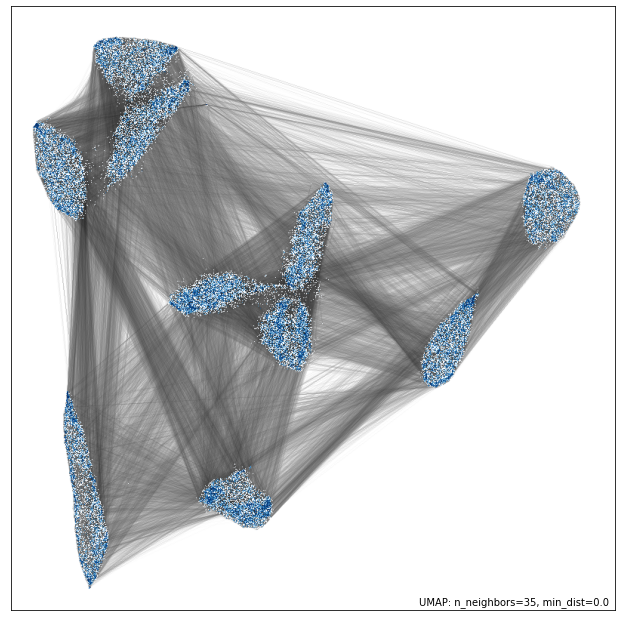

In [16]:
umap.plot.connectivity(umapper, show_points=True)

#### Cluster 2D space to get labels using HDBSCAN

In [17]:
lbls = hdbscan.HDBSCAN(
    min_samples=8,
    min_cluster_size=400,
).fit_predict(embedding)

In [23]:
lbls

array([8, 1, 5, ..., 5, 8, 2])

#### Split the data taken y (trian & test) to be labels got from HDBSCAN clustering (lbls) and not the original labels from the data (labels) 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    lbls,
                                                    stratify=lbls,
                                                    test_size = 0.25,
                                                    random_state=42)

#### Perform rundom forest classification 


In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=42, verbose=2)

In [27]:
best_random = rf_random.best_estimator_

#### check accuracy on best random estimator

In [28]:
predictions = best_random.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy = {:0.2f}%.'.format(accuracy))

Accuracy = 0.96%.
